In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Bidirectional
from keras.layers import GRU,SimpleRNN 
import tensorflow as tf

In [2]:
tf.random.set_seed(42)

In [3]:
def evaluation_metrics(Y_test, preds):
    # Creating a confusion matrix
    cm = confusion_matrix(Y_test, preds)

    # Printing the classification report
    print(classification_report(Y_test, preds))

    # Printing the F1 Score
    print("F1 Score: ", f1_score(Y_test, preds, average='weighted'))
    
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
    plt.title('Confusion Matrix')
    plt.xlabel('Y predict')
    plt.ylabel('Y test')
    plt.show()
    

In [4]:
# Reshape the data for LSTM
def create_sequences(data, target, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [5]:
# Reading Train Datasets
df_M0000=pd.read_csv(r'E:\Havelsan\Datasets\M0000_train_sensors.csv', engine='c')
df_M0000['target'] = 0
df_M2503=pd.read_csv(r'E:\Havelsan\Datasets\M2503_train_sensors.csv', engine='c')
df_M2503['target'] = 1
df_M2503['RunId'] = df_M2503['RunId']+35
df_M2508=pd.read_csv(r'E:\Havelsan\Datasets\M2508_train_sensors.csv', engine='c')
df_M2508['target'] = 2
df_M2508['RunId'] = df_M2508['RunId']+70
df1 = pd.concat([df_M0000,df_M2503,df_M2508], axis=0)
df1

,Time,Load,SeaTemp,WindSpeed,RunId,E02005,E02006,E02056,E03760,G00027,...,Z00518,Z00770,Z01970,Z02013,Z02436,Z02437,Z02477,Z02482,Linear,target
0,00:00:00,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1410,0
1,00:00:01,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1409,0
2,00:00:02,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1408,0
3,00:00:03,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1407,0
4,00:00:04,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706371,00:22:12,FAU,SW28,WC6,105,12.4602,25.1648,2757.11,12.3641,2.87130,...,16.0775,6,15.7389,31.6045,0.0,1.0,0.0,0.0,4,2
706372,00:22:13,FAU,SW28,WC6,105,12.4691,25.1000,2757.11,12.3815,2.87130,...,16.0790,6,15.7460,31.6222,0.0,1.0,0.0,0.0,3,2
706373,00:22:14,FAU,SW28,WC6,105,12.4781,25.0352,2757.11,12.3989,2.87130,...,16.0804,6,15.7530,31.6398,0.0,1.0,0.0,0.0,2,2
706374,00:22:15,FAU,SW28,WC6,105,12.4870,24.9703,2757.11,12.4163,2.87130,...,16.0819,6,15.7601,31.6574,0.0,1.0,0.0,0.0,1,2


In [6]:
# Setting initial conditions
SeaTemp='SW20'
WindSpeed='WC0'
Load='FAU'
df=df1
df=df[df['SeaTemp']==SeaTemp]
df=df[df['WindSpeed']==WindSpeed]
df=df[df['Load']==Load]
result=df
result.dropna(inplace=True)
result.reset_index(drop=True,inplace=True)
abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
df_train=result[abr_sensor_list+['target','Time','RunId']]
df_train

,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T02041,T02042,T02044,T04600,Z00518,Z01970,Z02013,target,Time,RunId
0,14.09040,266.676,0.000,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:00,1
1,14.09040,266.676,0.000,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:01,1
2,13.97260,347.270,0.000,13.73900,2.65347,2.83482,2.65506,73.9091,7.78951,2.15389,...,-1.81976,43.7985,48.0050,220.364,12.8062,12.9007,20.7326,0,00:00:02,1
3,13.98190,341.611,225.204,13.74950,2.65172,2.83517,2.65320,73.9162,7.78946,2.15398,...,-1.82216,43.7888,48.0049,220.367,12.8062,12.8980,20.6785,0,00:00:03,1
4,13.99120,335.952,450.408,13.76000,2.64996,2.83553,2.65133,73.9233,7.78941,2.15406,...,-1.82455,43.7792,48.0047,220.370,12.8063,12.8954,20.6244,0,00:00:04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121630,8.48925,267.164,2680.830,9.46467,2.05991,2.84047,1.75023,69.7798,7.94918,2.15171,...,-51.82170,43.8407,47.5894,220.566,12.8350,12.7650,19.6618,2,00:18:04,105
121631,7.55297,265.344,2679.090,8.72656,1.96473,2.84025,1.60343,69.0745,7.97611,2.15190,...,-51.87420,43.8381,47.5887,220.568,12.8414,12.6309,19.6039,2,00:18:05,105
121632,6.61668,263.523,2677.360,7.98846,1.86956,2.84002,1.45662,68.3693,8.00303,2.15208,...,-51.92680,43.8354,47.5880,220.571,12.8478,12.4968,19.5459,2,00:18:06,105
121633,5.68040,261.703,2675.620,7.25035,1.77438,2.83980,1.30982,67.6641,8.02995,2.15227,...,-51.97930,43.8327,47.5873,220.573,12.8543,12.3628,19.4880,2,00:18:07,105


In [7]:
df_train['Time'] = pd.to_timedelta(df_train['Time']).dt.total_seconds()
df_train

C:\Users\anilo\AppData\Local\Temp/ipykernel_5728/1635453357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Time'] = pd.to_timedelta(df_train['Time']).dt.total_seconds()


,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T02041,T02042,T02044,T04600,Z00518,Z01970,Z02013,target,Time,RunId
0,14.09040,266.676,0.000,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,0.0,1
1,14.09040,266.676,0.000,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,1.0,1
2,13.97260,347.270,0.000,13.73900,2.65347,2.83482,2.65506,73.9091,7.78951,2.15389,...,-1.81976,43.7985,48.0050,220.364,12.8062,12.9007,20.7326,0,2.0,1
3,13.98190,341.611,225.204,13.74950,2.65172,2.83517,2.65320,73.9162,7.78946,2.15398,...,-1.82216,43.7888,48.0049,220.367,12.8062,12.8980,20.6785,0,3.0,1
4,13.99120,335.952,450.408,13.76000,2.64996,2.83553,2.65133,73.9233,7.78941,2.15406,...,-1.82455,43.7792,48.0047,220.370,12.8063,12.8954,20.6244,0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121630,8.48925,267.164,2680.830,9.46467,2.05991,2.84047,1.75023,69.7798,7.94918,2.15171,...,-51.82170,43.8407,47.5894,220.566,12.8350,12.7650,19.6618,2,1084.0,105
121631,7.55297,265.344,2679.090,8.72656,1.96473,2.84025,1.60343,69.0745,7.97611,2.15190,...,-51.87420,43.8381,47.5887,220.568,12.8414,12.6309,19.6039,2,1085.0,105
121632,6.61668,263.523,2677.360,7.98846,1.86956,2.84002,1.45662,68.3693,8.00303,2.15208,...,-51.92680,43.8354,47.5880,220.571,12.8478,12.4968,19.5459,2,1086.0,105
121633,5.68040,261.703,2675.620,7.25035,1.77438,2.83980,1.30982,67.6641,8.02995,2.15227,...,-51.97930,43.8327,47.5873,220.573,12.8543,12.3628,19.4880,2,1087.0,105


In [8]:
# Reading Test Datasets
df_M0000=pd.read_csv(r'E:\Havelsan\Datasets\M0000_test_sensors.csv', engine='c')
df_M0000['target'] = 0
df_M2503=pd.read_csv(r'E:\Havelsan\Datasets\M2503_test_sensors.csv', engine='c')
df_M2503['target'] = 1
df_M2503['RunId'] = df_M2503['RunId']+18
df_M2508=pd.read_csv(r'E:\Havelsan\Datasets\M2508_test_sensors.csv', engine='c')
df_M2508['target'] = 2
df_M2508['RunId'] = df_M2508['RunId']+36
df2 = pd.concat([df_M0000,df_M2503,df_M2508], axis=0)
df2

,Time,Load,SeaTemp,WindSpeed,RunId,E02005,E02006,E02056,E03760,G00027,...,Z00518,Z00770,Z01970,Z02013,Z02436,Z02437,Z02477,Z02482,Linear,target
0,00:00:00,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1413,0
1,00:00:01,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1412,0
2,00:00:02,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1411,0
3,00:00:03,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1410,0
4,00:00:04,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363102,00:21:11,FAU,SW28,WC6,89,12.2713,24.8041,2854.77,11.3117,2.84142,...,16.2002,6,15.8048,32.3668,0.0,1.0,0.0,0.0,4,2
363103,00:21:12,FAU,SW28,WC6,89,12.2393,24.7914,2854.77,11.1414,2.83280,...,16.1980,6,15.8072,32.1289,0.0,1.0,0.0,0.0,3,2
363104,00:21:13,FAU,SW28,WC6,89,12.2073,24.7788,2854.77,10.9711,2.82417,...,16.1958,6,15.8096,31.8910,0.0,1.0,0.0,0.0,2,2
363105,00:21:14,FAU,SW28,WC6,89,12.4152,24.9221,2854.77,12.1801,2.86838,...,16.1937,6,15.8288,31.8499,0.0,1.0,0.0,0.0,1,2


In [9]:
# Setting initial conditions
SeaTemp='SW20'
WindSpeed='WC0'
Load='FAU'
df=df2
df=df[df['SeaTemp']==SeaTemp]
df=df[df['WindSpeed']==WindSpeed]
df=df[df['Load']==Load]
result=df
result.dropna(inplace=True)
result.reset_index(drop=True,inplace=True)
abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
df_test=result[abr_sensor_list+['target','Time','RunId']]
df_test

,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T02041,T02042,T02044,T04600,Z00518,Z01970,Z02013,target,Time,RunId
0,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:00,36
1,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:01,36
2,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:02,36
3,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:03,36
4,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,00:00:04,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63452,8.47049,270.430,2683.40,9.45213,2.05788,2.83369,1.74808,69.7673,7.95029,2.15251,...,-51.53260,43.8587,47.5799,220.394,12.8403,12.7263,19.6532,2,00:18:58,89
63453,7.53458,269.205,2682.75,8.71584,1.96306,2.83378,1.60162,69.0624,7.97706,2.15274,...,-51.57610,43.8622,47.5793,220.394,12.8466,12.5993,19.5918,2,00:18:59,89
63454,6.59867,267.980,2682.11,7.97954,1.86824,2.83387,1.45517,68.3576,8.00383,2.15297,...,-51.61970,43.8658,47.5788,220.394,12.8528,12.4724,19.5303,2,00:19:00,89
63455,5.66276,266.755,2681.46,7.24325,1.77343,2.83396,1.30871,67.6528,8.03059,2.15320,...,-51.66320,43.8693,47.5782,220.394,12.8591,12.3454,19.4689,2,00:19:01,89


In [10]:
df_test['Time'] = pd.to_timedelta(df_test['Time']).dt.total_seconds()
df_test

C:\Users\anilo\AppData\Local\Temp/ipykernel_5728/2860064012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Time'] = pd.to_timedelta(df_test['Time']).dt.total_seconds()


,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T02041,T02042,T02044,T04600,Z00518,Z01970,Z02013,target,Time,RunId
0,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,0.0,36
1,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,1.0,36
2,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,2.0,36
3,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,3.0,36
4,14.09040,266.676,0.00,13.87410,2.62669,2.83482,2.62672,74.0005,7.78959,2.15359,...,-1.81976,43.7985,48.0050,220.359,12.8062,12.8297,19.9715,0,4.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63452,8.47049,270.430,2683.40,9.45213,2.05788,2.83369,1.74808,69.7673,7.95029,2.15251,...,-51.53260,43.8587,47.5799,220.394,12.8403,12.7263,19.6532,2,1138.0,89
63453,7.53458,269.205,2682.75,8.71584,1.96306,2.83378,1.60162,69.0624,7.97706,2.15274,...,-51.57610,43.8622,47.5793,220.394,12.8466,12.5993,19.5918,2,1139.0,89
63454,6.59867,267.980,2682.11,7.97954,1.86824,2.83387,1.45517,68.3576,8.00383,2.15297,...,-51.61970,43.8658,47.5788,220.394,12.8528,12.4724,19.5303,2,1140.0,89
63455,5.66276,266.755,2681.46,7.24325,1.77343,2.83396,1.30871,67.6528,8.03059,2.15320,...,-51.66320,43.8693,47.5782,220.394,12.8591,12.3454,19.4689,2,1141.0,89


# Multilayer Perceptron

In [11]:
# Train split
X_train = df_train[abr_sensor_list]# Features
Y_train = df_train['target']  # Target

In [12]:
# Test split
X_test = df_test[abr_sensor_list] # Features
Y_test = df_test['target']  # Target

**Test I**

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
n_features = 36
n_classes = 3

# Define the model
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(n_features,)))

model.add(Dense(64, activation='relu'))

model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()

Epoch 1/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.1251 - accuracy: 0.9394 - val_loss: 0.1891 - val_accuracy: 0.8990
Epoch 2/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.0963 - accuracy: 0.9488 - val_loss: 0.2948 - val_accuracy: 0.8874
Epoch 3/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0923 - accuracy: 0.9507 - val_loss: 0.2202 - val_accuracy: 0.9046
Epoch 4/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.0915 - accuracy: 0.9512 - val_loss: 0.2062 - val_accuracy: 0.9031
Epoch 5/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.0901 - accuracy: 0.9516 - val_loss: 0.2364 - val_accuracy: 0.9040
Epoch 6/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.0891 - accuracy: 0.9530 - val_loss: 0.1513 - val_accuracy: 0.9190
Epoch 7/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.0879 - accuracy: 0.9540 - val_loss: 0.2291 - val_accuracy:

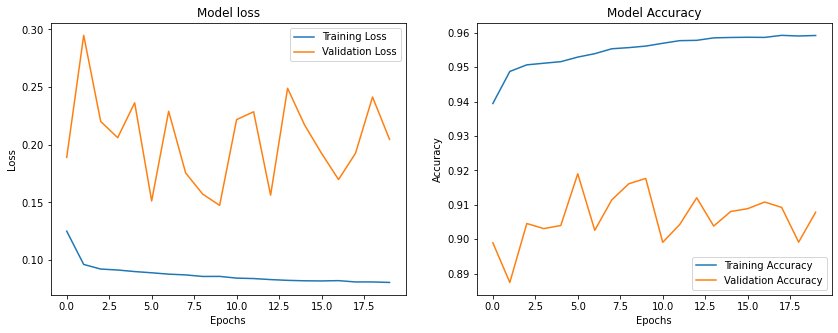

In [15]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1984/1984 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     21594
           1       0.95      0.95      0.95     22026
           2       1.00      0.91      0.95     19837

    accuracy                           0.95     63457
   macro avg       0.95      0.94      0.95     63457
weighted avg       0.95      0.95      0.95     63457

F1 Score:  0.9452572143880923


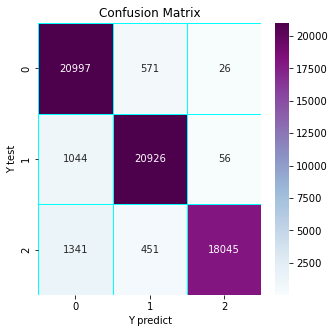

In [16]:
y_pred = model.predict(X_test_scaled)
preds = np.argmax(y_pred, axis=1)
evaluation_metrics(Y_test, preds)

**Test II**

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
n_features = 36
n_classes = 3

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, Y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()

Epoch 1/20
3041/3041 [==============================] - 6s 2ms/step - loss: 0.2629 - accuracy: 0.8988 - val_loss: 0.3744 - val_accuracy: 0.8389
Epoch 2/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1739 - accuracy: 0.9263 - val_loss: 0.4738 - val_accuracy: 0.8168
Epoch 3/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1597 - accuracy: 0.9285 - val_loss: 0.2924 - val_accuracy: 0.8626
Epoch 4/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1472 - accuracy: 0.9315 - val_loss: 0.2073 - val_accuracy: 0.8850
Epoch 5/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1398 - accuracy: 0.9322 - val_loss: 0.2974 - val_accuracy: 0.8718
Epoch 6/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1377 - accuracy: 0.9317 - val_loss: 0.3163 - val_accuracy: 0.8731
Epoch 7/20
3041/3041 [==============================] - 5s 2ms/step - loss: 0.1345 - accuracy: 0.9326 - val_loss: 0.2266 - val_accuracy:

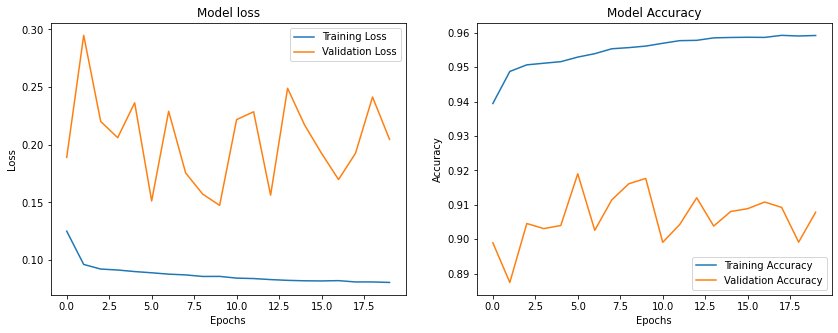

In [19]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1984/1984 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21594
           1       1.00      0.91      0.95     22026
           2       1.00      0.88      0.94     19837

    accuracy                           0.93     63457
   macro avg       0.94      0.93      0.93     63457
weighted avg       0.94      0.93      0.93     63457

F1 Score:  0.9321261771289032


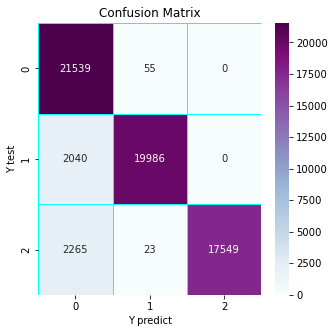

In [20]:
y_pred = model.predict(X_test_scaled)
preds = np.argmax(y_pred, axis=1)
evaluation_metrics(Y_test, preds)

**Test III**

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, Y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()


Epoch 1/20
3041/3041 [==============================] - 9s 3ms/step - loss: 1.0205 - accuracy: 0.9119 - val_loss: 0.3096 - val_accuracy: 0.9194
Epoch 2/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3605 - accuracy: 0.9230 - val_loss: 0.6619 - val_accuracy: 0.8293
Epoch 3/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3583 - accuracy: 0.9238 - val_loss: 0.4863 - val_accuracy: 0.8675
Epoch 4/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3564 - accuracy: 0.9238 - val_loss: 0.5015 - val_accuracy: 0.8524
Epoch 5/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3548 - accuracy: 0.9237 - val_loss: 0.7045 - val_accuracy: 0.8257
Epoch 6/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3556 - accuracy: 0.9237 - val_loss: 0.7816 - val_accuracy: 0.7877
Epoch 7/20
3041/3041 [==============================] - 8s 3ms/step - loss: 0.3519 - accuracy: 0.9236 - val_loss: 0.6635 - val_accuracy:

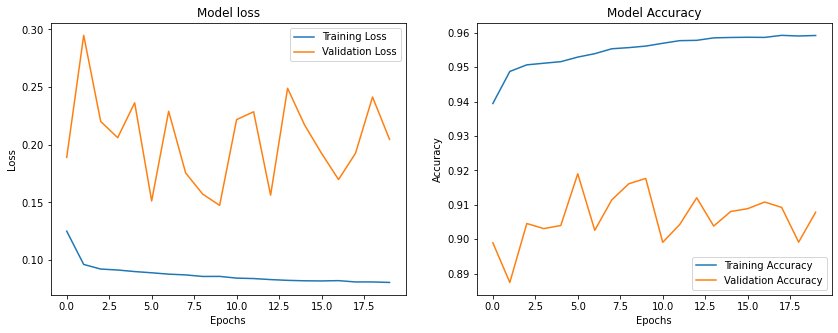

In [23]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1984/1984 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21594
           1       0.97      0.92      0.95     22026
           2       1.00      0.85      0.92     19837

    accuracy                           0.92     63457
   macro avg       0.93      0.92      0.92     63457
weighted avg       0.93      0.92      0.92     63457

F1 Score:  0.9231461407124341


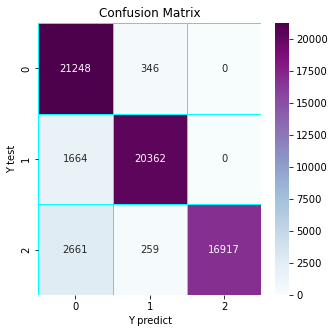

In [24]:
y_pred = model.predict(X_test_scaled)
preds = np.argmax(y_pred, axis=1)
evaluation_metrics(Y_test, preds)

**Test IV**

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
n_features = 36
n_classes = 3

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,)))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dropout(0.5))  # Add Dropout
model.add(Dense(64, activation='relu'))

model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dropout(0.5))  # Add Dropout
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
model.fit(X_train_scaled, Y_train, epochs=100, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
model.summary()


Epoch 1/100
3041/3041 [==============================] - 9s 3ms/step - loss: 0.2034 - accuracy: 0.9221 - val_loss: 0.2787 - val_accuracy: 0.8725
Epoch 2/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1402 - accuracy: 0.9396 - val_loss: 0.3000 - val_accuracy: 0.8770
Epoch 3/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1308 - accuracy: 0.9419 - val_loss: 0.2533 - val_accuracy: 0.8922
Epoch 4/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1278 - accuracy: 0.9423 - val_loss: 0.2949 - val_accuracy: 0.8860
Epoch 5/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1223 - accuracy: 0.9435 - val_loss: 0.3315 - val_accuracy: 0.8965
Epoch 6/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1211 - accuracy: 0.9437 - val_loss: 0.3032 - val_accuracy: 0.9042
Epoch 7/100
3041/3041 [==============================] - 8s 3ms/step - loss: 0.1204 - accuracy: 0.9439 - val_loss: 0.3310 - val_ac

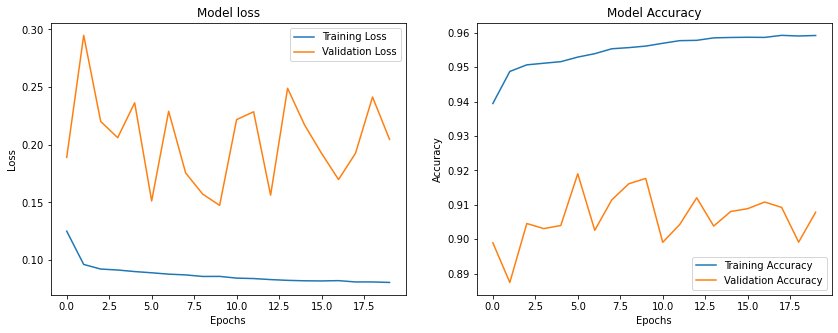

In [27]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1984/1984 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     21594
           1       1.00      0.91      0.95     22026
           2       1.00      0.90      0.95     19837

    accuracy                           0.94     63457
   macro avg       0.95      0.94      0.94     63457
weighted avg       0.95      0.94      0.94     63457

F1 Score:  0.9375373925585101


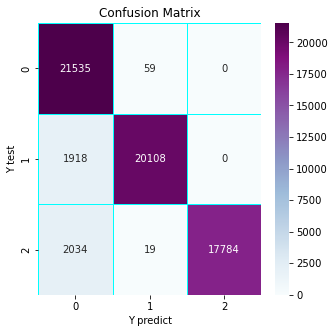

In [28]:
y_pred = model.predict(X_test_scaled)
preds = np.argmax(y_pred, axis=1)
evaluation_metrics(Y_test, preds)

**Test V**

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
start_neurons = 512
dropout_rate=0.5
activation='tanh'
# Create model
model = Sequential()

# Input Layer
model.add(Dense(start_neurons,input_shape=(n_features,), activation=activation))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layer 1
model.add(Dense(start_neurons // 2, activation=activation))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layer 2
model.add(Dense(start_neurons // 4, activation=activation))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layer 3
model.add(Dense(start_neurons // 8, activation=activation))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate / 2))

# Output Layer
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
model.fit(X_train_scaled, Y_train, epochs=100, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
model.summary()

Epoch 1/100
3041/3041 [==============================] - 18s 5ms/step - loss: 0.2382 - accuracy: 0.9090 - val_loss: 0.2165 - val_accuracy: 0.8890
Epoch 2/100
3041/3041 [==============================] - 17s 6ms/step - loss: 0.1623 - accuracy: 0.9310 - val_loss: 0.3177 - val_accuracy: 0.8719
Epoch 3/100
3041/3041 [==============================] - 17s 6ms/step - loss: 0.1429 - accuracy: 0.9361 - val_loss: 0.2590 - val_accuracy: 0.8872
Epoch 4/100
3041/3041 [==============================] - 18s 6ms/step - loss: 0.1328 - accuracy: 0.9388 - val_loss: 0.2665 - val_accuracy: 0.8734
Epoch 5/100
3041/3041 [==============================] - 18s 6ms/step - loss: 0.1257 - accuracy: 0.9406 - val_loss: 0.2610 - val_accuracy: 0.8713
Epoch 6/100
3041/3041 [==============================] - 18s 6ms/step - loss: 0.1219 - accuracy: 0.9422 - val_loss: 0.2595 - val_accuracy: 0.8818
Epoch 7/100
3041/3041 [==============================] - 16s 5ms/step - loss: 0.1192 - accuracy: 0.9430 - val_loss: 0.2437 -

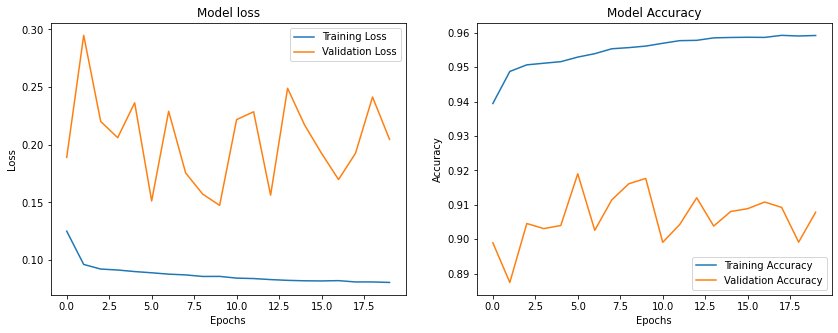

In [31]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1984/1984 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     21594
           1       0.85      1.00      0.92     22026
           2       1.00      0.89      0.94     19837

    accuracy                           0.93     63457
   macro avg       0.94      0.93      0.93     63457
weighted avg       0.94      0.93      0.93     63457

F1 Score:  0.9343071624293936


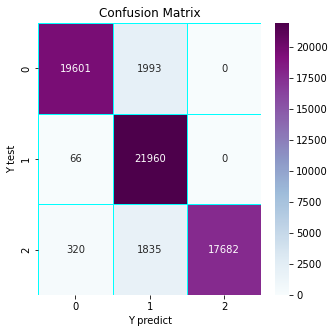

In [32]:
y_pred = model.predict(X_test_scaled)
preds = np.argmax(y_pred, axis=1)
evaluation_metrics(Y_test, preds)

# Recurrent Neural Network (RNN)

**What is Recurrent Neural Network ?**<br>
**-**  Recurrent Neural Network is basically a generalization of feed-forward neural network that has an internal memory.RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. For making a decision, it considers the current input and the output that it has learned from the previous input.

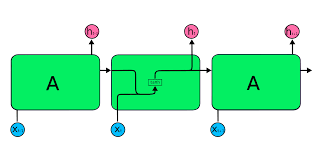

**Test VI**

In [33]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [34]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [35]:

target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62863, 10, 36)
Y test shape: (62863, 3)


In [36]:
# Define the RNN model
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3014/3014 [==============================] - 18s 6ms/step - loss: 0.2590 - accuracy: 0.9005 - val_loss: 0.3983 - val_accuracy: 0.7957
Epoch 2/10
3014/3014 [==============================] - 16s 5ms/step - loss: 0.1813 - accuracy: 0.9189 - val_loss: 0.2492 - val_accuracy: 0.8732
Epoch 3/10
3014/3014 [==============================] - 16s 5ms/step - loss: 0.1766 - accuracy: 0.9215 - val_loss: 0.3349 - val_accuracy: 0.8311
Epoch 4/10
3014/3014 [==============================] - 17s 6ms/step - loss: 0.1647 - accuracy: 0.9252 - val_loss: 0.2573 - val_accuracy: 0.8807
Epoch 5/10
3014/3014 [==============================] - 17s 6ms/step - loss: 0.1603 - accuracy: 0.9261 - val_loss: 0.3339 - val_accuracy: 0.8368
Epoch 6/10
3014/3014 [==============================] - 17s 6ms/step - loss: 0.1549 - accuracy: 0.9282 - val_loss: 0.3182 - val_accuracy: 0.8691
Epoch 7/10
3014/3014 [==============================] - 19s 6ms/step - loss: 0.1512 - accuracy: 0.9288 - val_loss: 0.3003 - val_ac

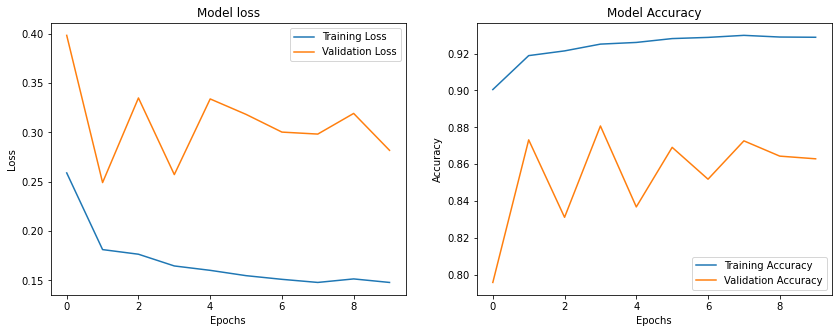

In [37]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1965/1965 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     21396
           1       0.87      0.97      0.91     21828
           2       1.00      0.87      0.93     19639

    accuracy                           0.92     62863
   macro avg       0.93      0.92      0.92     62863
weighted avg       0.93      0.92      0.92     62863

F1 Score:  0.9214219635518405


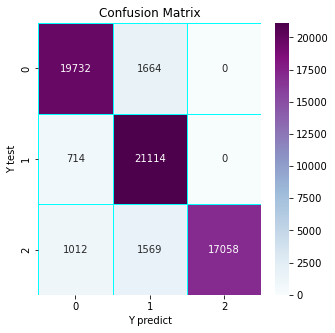

In [38]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test VII**

In [39]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [40]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [41]:

target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62863, 10, 36)
Y test shape: (62863, 3)


In [42]:
# Define the RNN model
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3014/3014 [==============================] - 20s 6ms/step - loss: 0.1303 - accuracy: 0.9404 - val_loss: 0.1708 - val_accuracy: 0.9003
Epoch 2/10
3014/3014 [==============================] - 18s 6ms/step - loss: 0.1067 - accuracy: 0.9469 - val_loss: 0.2150 - val_accuracy: 0.9015
Epoch 3/10
3014/3014 [==============================] - 18s 6ms/step - loss: 0.0999 - accuracy: 0.9497 - val_loss: 0.1836 - val_accuracy: 0.9077
Epoch 4/10
3014/3014 [==============================] - 18s 6ms/step - loss: 0.0979 - accuracy: 0.9504 - val_loss: 0.2027 - val_accuracy: 0.9123
Epoch 5/10
3014/3014 [==============================] - 17s 6ms/step - loss: 0.0978 - accuracy: 0.9508 - val_loss: 0.1796 - val_accuracy: 0.9074
Epoch 6/10
3014/3014 [==============================] - 17s 6ms/step - loss: 0.0946 - accuracy: 0.9519 - val_loss: 0.1960 - val_accuracy: 0.9104
Epoch 7/10
3014/3014 [==============================] - 16s 5ms/step - loss: 0.0937 - accuracy: 0.9517 - val_loss: 0.1949 - val_ac

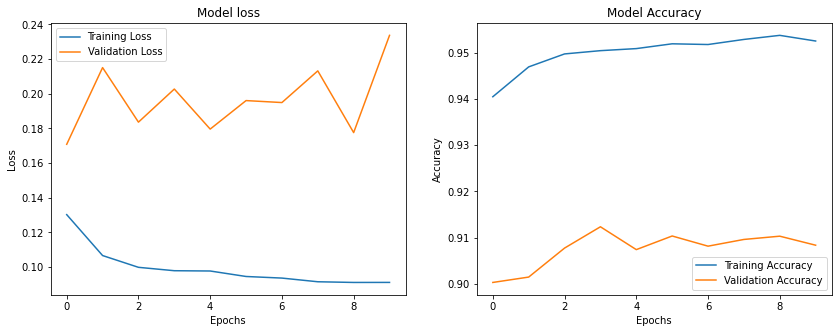

In [43]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1965/1965 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     21396
           1       0.95      0.95      0.95     21828
           2       1.00      0.91      0.95     19639

    accuracy                           0.95     62863
   macro avg       0.95      0.94      0.95     62863
weighted avg       0.95      0.95      0.95     62863

F1 Score:  0.9458828798941749


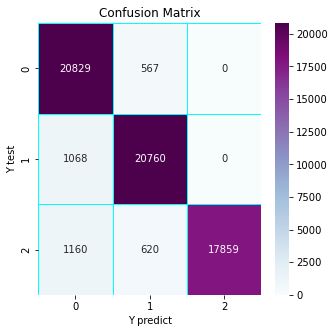

In [44]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test VIII**

In [45]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [46]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [47]:

target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62863, 10, 36)
Y test shape: (62863, 3)


In [48]:

# Define the model
model = Sequential()

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
1507/1507 [==============================] - 15s 9ms/step - loss: 0.1310 - accuracy: 0.9392 - val_loss: 0.2589 - val_accuracy: 0.8874
Epoch 2/20
1507/1507 [==============================] - 14s 10ms/step - loss: 0.1077 - accuracy: 0.9461 - val_loss: 0.2952 - val_accuracy: 0.8969
Epoch 3/20
1507/1507 [==============================] - 15s 10ms/step - loss: 0.1039 - accuracy: 0.9485 - val_loss: 0.2037 - val_accuracy: 0.9077
Epoch 4/20
1507/1507 [==============================] - 14s 9ms/step - loss: 0.1005 - accuracy: 0.9493 - val_loss: 0.1740 - val_accuracy: 0.9149
Epoch 5/20
1507/1507 [==============================] - 15s 10ms/step - loss: 0.1002 - accuracy: 0.9492 - val_loss: 0.1749 - val_accuracy: 0.8987
Epoch 6/20
1507/1507 [==============================] - 14s 9ms/step - loss: 0.1012 - accuracy: 0.9490 - val_loss: 0.1970 - val_accuracy: 0.9043
Epoch 7/20
1507/1507 [==============================] - 14s 9ms/step - loss: 0.0990 - accuracy: 0.9494 - val_loss: 0.1907 - val

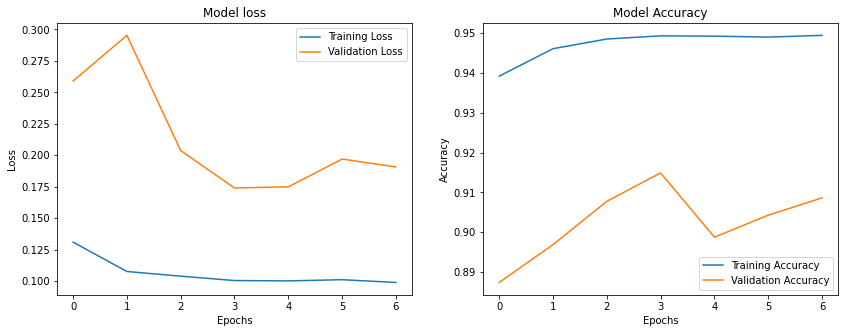

In [49]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1965/1965 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     21396
           1       0.99      0.93      0.96     21828
           2       1.00      0.91      0.95     19639

    accuracy                           0.95     62863
   macro avg       0.95      0.94      0.95     62863
weighted avg       0.95      0.95      0.95     62863

F1 Score:  0.9463302756478085


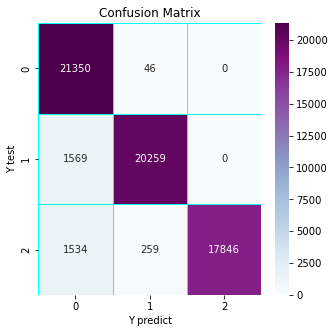

In [50]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

# Long short-term memory (LSTM)

**What is Long short-term memory ?**<br>
**-**  Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.The architecture of an LSTM cell involves three main components: Forget Gate, Input Gate, Cell State,Output Gate

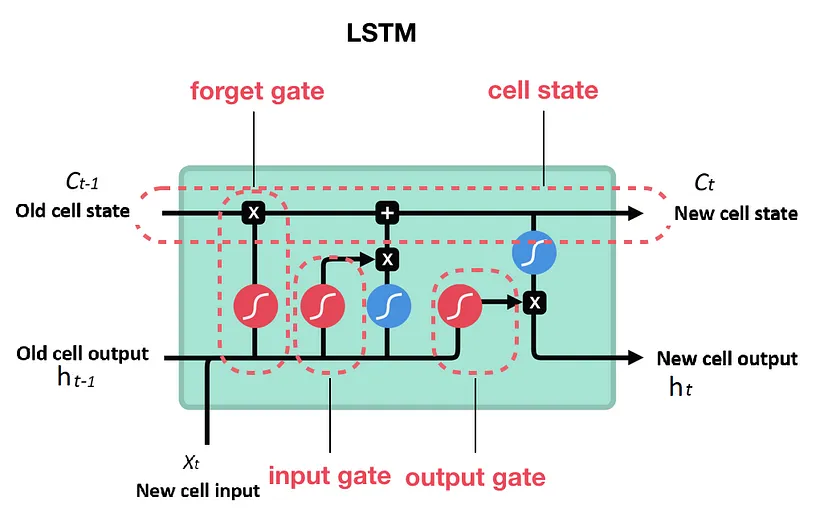

**Test IX**

In [51]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [52]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [53]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [54]:

target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62863, 10, 36)
Y test shape: (62863, 3)


In [55]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3014/3014 [==============================] - 41s 12ms/step - loss: 0.2183 - accuracy: 0.9093 - val_loss: 0.7550 - val_accuracy: 0.7315
Epoch 2/10
3014/3014 [==============================] - 35s 12ms/step - loss: 0.1625 - accuracy: 0.9245 - val_loss: 0.2488 - val_accuracy: 0.8803
Epoch 3/10
3014/3014 [==============================] - 38s 13ms/step - loss: 0.1499 - accuracy: 0.9275 - val_loss: 0.2913 - val_accuracy: 0.8577
Epoch 4/10
3014/3014 [==============================] - 39s 13ms/step - loss: 0.1431 - accuracy: 0.9306 - val_loss: 0.4088 - val_accuracy: 0.7951
Epoch 5/10
3014/3014 [==============================] - 37s 12ms/step - loss: 0.1393 - accuracy: 0.9310 - val_loss: 0.1770 - val_accuracy: 0.8982
Epoch 6/10
3014/3014 [==============================] - 37s 12ms/step - loss: 0.1370 - accuracy: 0.9323 - val_loss: 0.3120 - val_accuracy: 0.8399
Epoch 7/10
3014/3014 [==============================] - 35s 11ms/step - loss: 0.1338 - accuracy: 0.9334 - val_loss: 0.2294 -

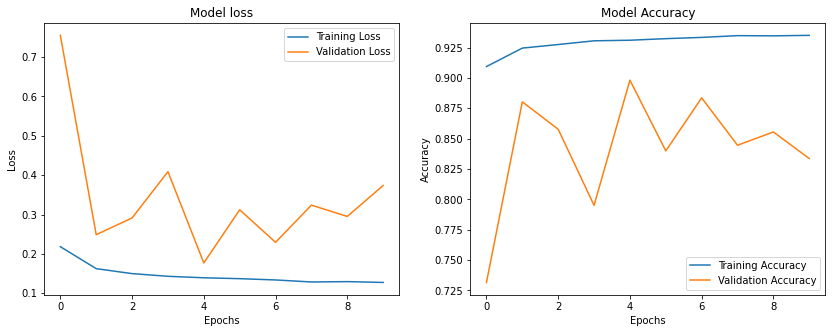

In [56]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1965/1965 [==============================] - 9s 4ms/step
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     21396
           1       0.90      0.95      0.92     21828
           2       1.00      0.84      0.91     19639

    accuracy                           0.91     62863
   macro avg       0.92      0.91      0.91     62863
weighted avg       0.92      0.91      0.91     62863

F1 Score:  0.9094708142680578


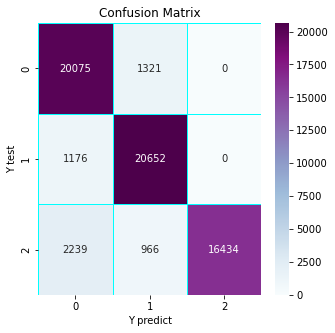

In [57]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test X**

In [58]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [59]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120524, 10, 36)
Y train shape: (120524, 3)


In [60]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 10

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62863, 10, 36)
Y test shape: (62863, 3)


In [61]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3014/3014 [==============================] - 39s 12ms/step - loss: 0.1137 - accuracy: 0.9422 - val_loss: 0.2273 - val_accuracy: 0.8858
Epoch 2/10
3014/3014 [==============================] - 34s 11ms/step - loss: 0.0950 - accuracy: 0.9493 - val_loss: 0.2155 - val_accuracy: 0.9038
Epoch 3/10
3014/3014 [==============================] - 34s 11ms/step - loss: 0.0928 - accuracy: 0.9512 - val_loss: 0.1932 - val_accuracy: 0.9079
Epoch 4/10
3014/3014 [==============================] - 33s 11ms/step - loss: 0.0895 - accuracy: 0.9525 - val_loss: 0.1871 - val_accuracy: 0.9097
Epoch 5/10
3014/3014 [==============================] - 35s 12ms/step - loss: 0.0884 - accuracy: 0.9529 - val_loss: 0.1558 - val_accuracy: 0.9158
Epoch 6/10
3014/3014 [==============================] - 35s 11ms/step - loss: 0.0861 - accuracy: 0.9542 - val_loss: 0.1647 - val_accuracy: 0.9119
Epoch 7/10
3014/3014 [==============================] - 41s 14ms/step - loss: 0.0843 - accuracy: 0.9555 - val_loss: 0.1972 -

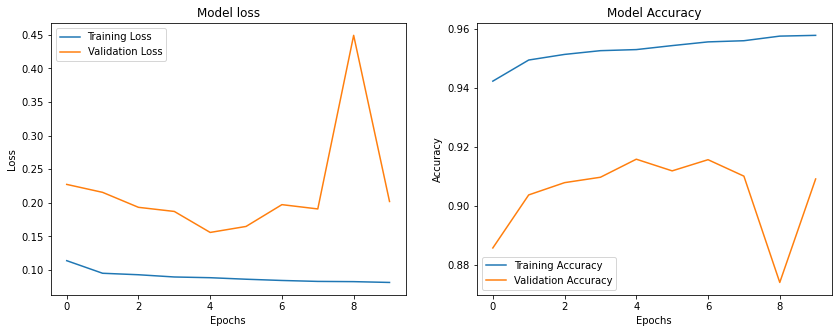

In [62]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1965/1965 [==============================] - 9s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     21396
           1       0.97      0.95      0.96     21828
           2       1.00      0.91      0.95     19639

    accuracy                           0.95     62863
   macro avg       0.95      0.95      0.95     62863
weighted avg       0.95      0.95      0.95     62863

F1 Score:  0.949189258634124


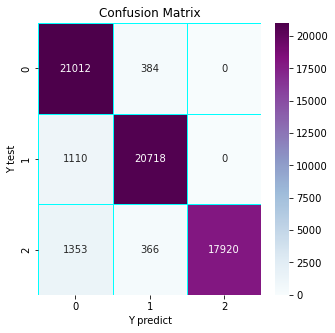

In [63]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test XI**

In [64]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [65]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [66]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [67]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2988/2988 [==============================] - 52s 16ms/step - loss: 0.1081 - accuracy: 0.9459 - val_loss: 0.1982 - val_accuracy: 0.9029
Epoch 2/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0875 - accuracy: 0.9536 - val_loss: 0.2213 - val_accuracy: 0.8976
Epoch 3/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0833 - accuracy: 0.9562 - val_loss: 0.1821 - val_accuracy: 0.9103
Epoch 4/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0802 - accuracy: 0.9575 - val_loss: 0.2321 - val_accuracy: 0.9131
Epoch 5/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0786 - accuracy: 0.9580 - val_loss: 0.1682 - val_accuracy: 0.9222
Epoch 6/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0797 - accuracy: 0.9584 - val_loss: 0.1824 - val_accuracy: 0.9177
Epoch 7/10
2988/2988 [==============================] - 48s 16ms/step - loss: 0.0758 - accuracy: 0.9596 - val_loss: 0.1442 -

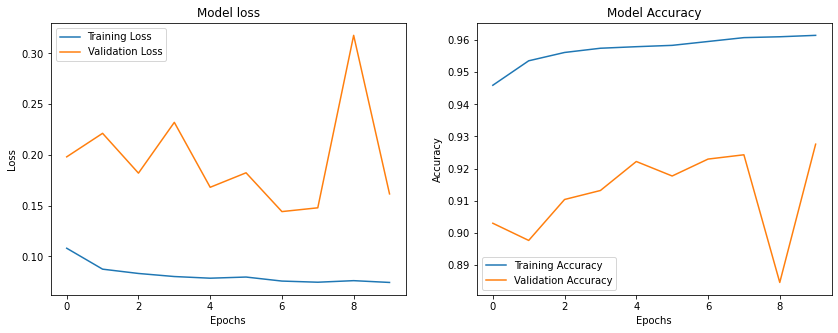

In [68]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 16s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     21216
           1       0.95      0.96      0.96     21648
           2       0.99      0.93      0.96     19459

    accuracy                           0.96     62323
   macro avg       0.96      0.95      0.96     62323
weighted avg       0.96      0.96      0.96     62323

F1 Score:  0.9553056165955642


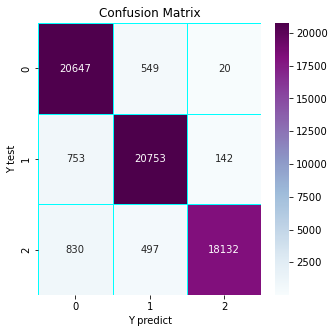

In [69]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test XII**

In [70]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [71]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 7

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (120827, 7, 36)
Y train shape: (120827, 3)


In [72]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 7

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (63025, 7, 36)
Y test shape: (63025, 3)


In [73]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3021/3021 [==============================] - 33s 10ms/step - loss: 0.1161 - accuracy: 0.9422 - val_loss: 0.2259 - val_accuracy: 0.8936
Epoch 2/10
3021/3021 [==============================] - 29s 10ms/step - loss: 0.0954 - accuracy: 0.9488 - val_loss: 0.2375 - val_accuracy: 0.9040
Epoch 3/10
3021/3021 [==============================] - 29s 10ms/step - loss: 0.0936 - accuracy: 0.9499 - val_loss: 0.2437 - val_accuracy: 0.8994
Epoch 4/10
3021/3021 [==============================] - 29s 10ms/step - loss: 0.0910 - accuracy: 0.9520 - val_loss: 0.2463 - val_accuracy: 0.9035
Epoch 5/10
3021/3021 [==============================] - 29s 10ms/step - loss: 0.0899 - accuracy: 0.9525 - val_loss: 0.2122 - val_accuracy: 0.9042
Epoch 6/10
3021/3021 [==============================] - 29s 10ms/step - loss: 0.0898 - accuracy: 0.9528 - val_loss: 0.1673 - val_accuracy: 0.9106
Epoch 7/10
3021/3021 [==============================] - 29s 9ms/step - loss: 0.0873 - accuracy: 0.9546 - val_loss: 0.2063 - 

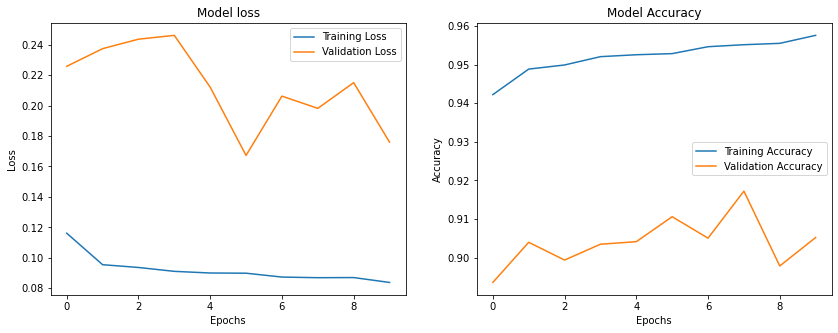

In [74]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1970/1970 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     21450
           1       0.94      0.95      0.95     21882
           2       1.00      0.91      0.95     19693

    accuracy                           0.95     63025
   macro avg       0.95      0.95      0.95     63025
weighted avg       0.95      0.95      0.95     63025

F1 Score:  0.9499845267563476


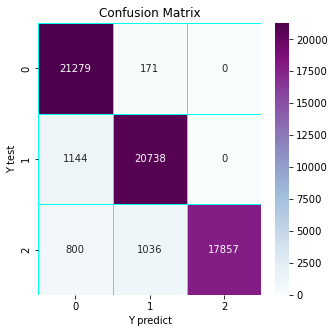

In [75]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test XIII**

In [76]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [77]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [78]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [79]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
2988/2988 [==============================] - 233s 76ms/step - loss: 0.1095 - accuracy: 0.9458 - val_loss: 0.2003 - val_accuracy: 0.9024
Epoch 2/50
2988/2988 [==============================] - 233s 78ms/step - loss: 0.0939 - accuracy: 0.9509 - val_loss: 0.3960 - val_accuracy: 0.8615
Epoch 3/50
2988/2988 [==============================] - 235s 79ms/step - loss: 0.0864 - accuracy: 0.9540 - val_loss: 0.1785 - val_accuracy: 0.9053
Epoch 4/50
2988/2988 [==============================] - 234s 78ms/step - loss: 0.0828 - accuracy: 0.9557 - val_loss: 0.2369 - val_accuracy: 0.9070
Epoch 5/50
2988/2988 [==============================] - 232s 78ms/step - loss: 0.0873 - accuracy: 0.9558 - val_loss: 0.1902 - val_accuracy: 0.9080
Epoch 6/50
2988/2988 [==============================] - 233s 78ms/step - loss: 0.0799 - accuracy: 0.9570 - val_loss: 0.1945 - val_accuracy: 0.9147
Epoch 7/50
2988/2988 [==============================] - 234s 78ms/step - loss: 0.0791 - accuracy: 0.9583 - val_loss: 0

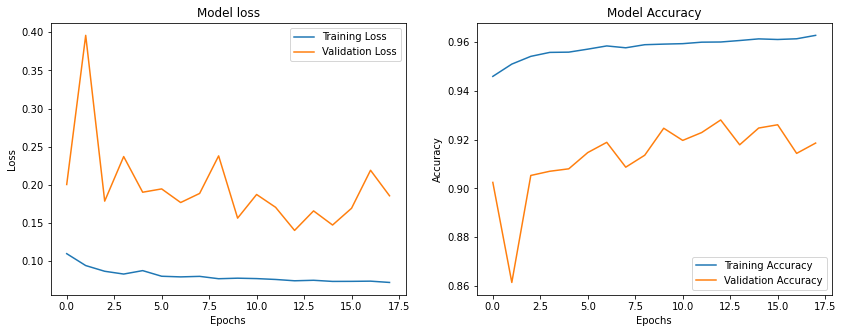

In [80]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 41s 21ms/step
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     21216
           1       0.99      0.94      0.96     21648
           2       1.00      0.92      0.96     19459

    accuracy                           0.95     62323
   macro avg       0.96      0.95      0.95     62323
weighted avg       0.96      0.95      0.95     62323

F1 Score:  0.9531825989979016


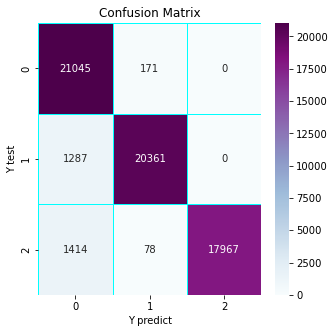

In [81]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

# Gated Recurrent Unit (GRU)

**What is Gated Recurrent Unit ?**<br>
**-**  The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) used in deep learning for tasks that involve sequential data.The GRU, like the LSTM, is designed to have more effective long-term memory compared to the basic RNN model. This is because it incorporates gating units that modulate the flow of information inside the unit. However, GRU has a simpler structure than LSTM as it has two gates (reset and update gates), whereas the LSTM has three gates (input, forget, and output gates).

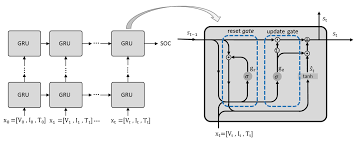

**Test XIV**

In [82]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [83]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [84]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [85]:
# Define the model
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2988/2988 [==============================] - 57s 18ms/step - loss: 0.1107 - accuracy: 0.9474 - val_loss: 0.2565 - val_accuracy: 0.8994
Epoch 2/10
2988/2988 [==============================] - 59s 20ms/step - loss: 0.0872 - accuracy: 0.9548 - val_loss: 0.2235 - val_accuracy: 0.9101
Epoch 3/10
2988/2988 [==============================] - 70s 24ms/step - loss: 0.0810 - accuracy: 0.9568 - val_loss: 0.0976 - val_accuracy: 0.9500
Epoch 4/10
2988/2988 [==============================] - 55s 18ms/step - loss: 0.0795 - accuracy: 0.9583 - val_loss: 0.2624 - val_accuracy: 0.9076
Epoch 5/10
2988/2988 [==============================] - 55s 18ms/step - loss: 0.0781 - accuracy: 0.9587 - val_loss: 0.1765 - val_accuracy: 0.9227
Epoch 6/10
2988/2988 [==============================] - 55s 18ms/step - loss: 0.0760 - accuracy: 0.9599 - val_loss: 0.1423 - val_accuracy: 0.9280
Epoch 7/10
2988/2988 [==============================] - 55s 18ms/step - loss: 0.0741 - accuracy: 0.9606 - val_loss: 0.1459 -

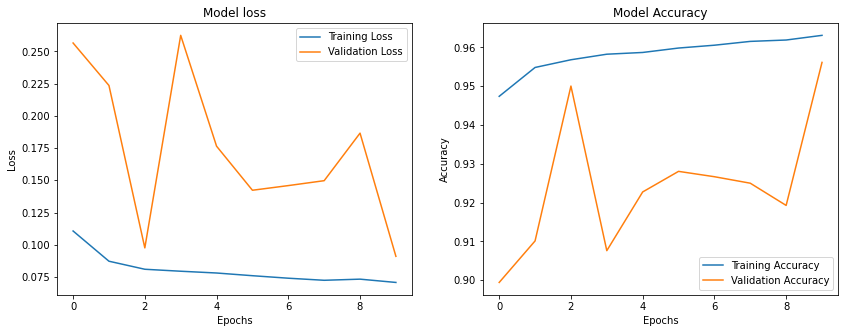

In [86]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 12s 6ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     21216
           1       1.00      0.93      0.96     21648
           2       0.98      0.96      0.97     19459

    accuracy                           0.96     62323
   macro avg       0.96      0.96      0.96     62323
weighted avg       0.96      0.96      0.96     62323

F1 Score:  0.9624147640203269


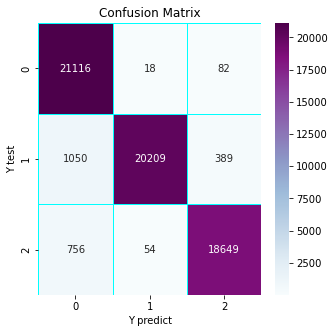

In [87]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test XV**

In [88]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [89]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [90]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [91]:

# Define the model
model = Sequential()

model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(GRU(units=100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
1494/1494 [==============================] - 79s 51ms/step - loss: 0.1117 - accuracy: 0.9467 - val_loss: 0.2563 - val_accuracy: 0.8851
Epoch 2/20
1494/1494 [==============================] - 68s 46ms/step - loss: 0.0870 - accuracy: 0.9552 - val_loss: 0.1455 - val_accuracy: 0.9180
Epoch 3/20
1494/1494 [==============================] - 68s 46ms/step - loss: 0.0809 - accuracy: 0.9576 - val_loss: 0.0678 - val_accuracy: 0.9724
Epoch 4/20
1494/1494 [==============================] - 68s 46ms/step - loss: 0.0854 - accuracy: 0.9556 - val_loss: 0.1728 - val_accuracy: 0.9179
Epoch 5/20
1494/1494 [==============================] - 69s 46ms/step - loss: 0.0774 - accuracy: 0.9587 - val_loss: 0.2145 - val_accuracy: 0.9154
Epoch 6/20
1494/1494 [==============================] - 68s 46ms/step - loss: 0.0753 - accuracy: 0.9603 - val_loss: 0.1638 - val_accuracy: 0.9260


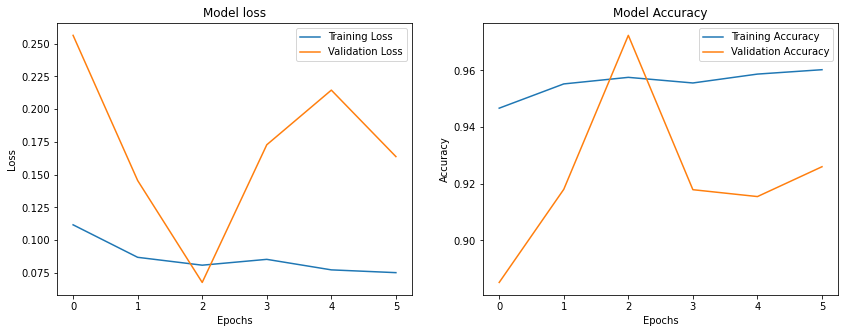

In [92]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 18s 9ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     21216
           1       0.94      0.97      0.95     21648
           2       1.00      0.93      0.96     19459

    accuracy                           0.95     62323
   macro avg       0.96      0.95      0.95     62323
weighted avg       0.95      0.95      0.95     62323

F1 Score:  0.9534633702160036


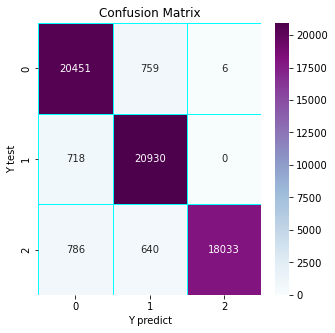

In [93]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

# Bidirectional LSTM

**What is Gated Recurrent Unit ?**<br>
**-**  Bidirectional LSTMs are a type of LSTM (Long Short Term Memory) network introduced to expand the capacity of classic LSTMs. The main idea behind them is to have two LSTMs for each time step of your data: one that processes the data from "past to future" (i.e., as it appears in the sequence) and another one that processes it from "future to past" (i.e., in reverse order).

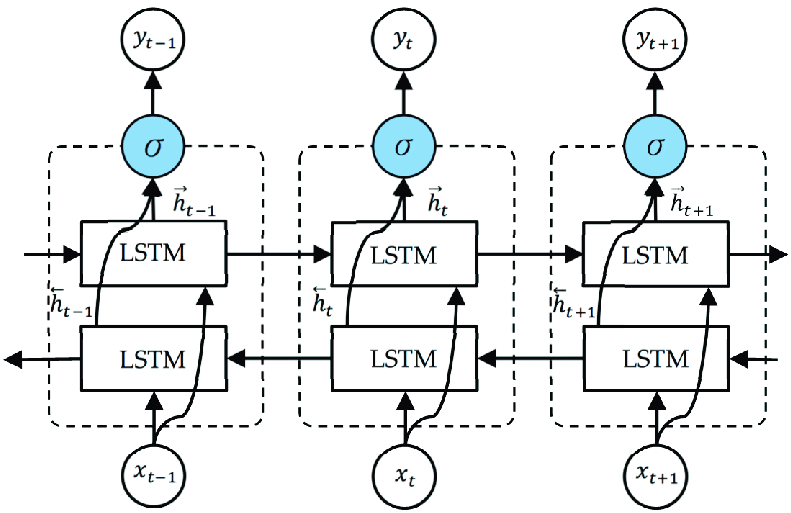

**Test XVI**

In [94]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [95]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [96]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [97]:
# Define the LSTM model
model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/10
3735/3735 [==============================] - 105s 26ms/step - loss: 0.1125 - accuracy: 0.9411 - val_loss: 0.0964 - val_accuracy: 0.9445
Epoch 2/10
3735/3735 [==============================] - 101s 27ms/step - loss: 0.0955 - accuracy: 0.9500 - val_loss: 0.0942 - val_accuracy: 0.9467
Epoch 3/10
3735/3735 [==============================] - 102s 27ms/step - loss: 0.0904 - accuracy: 0.9526 - val_loss: 0.0848 - val_accuracy: 0.9631
Epoch 4/10
3735/3735 [==============================] - 102s 27ms/step - loss: 0.0888 - accuracy: 0.9532 - val_loss: 0.0846 - val_accuracy: 0.9539
Epoch 5/10
3735/3735 [==============================] - 101s 27ms/step - loss: 0.0863 - accuracy: 0.9549 - val_loss: 0.1029 - val_accuracy: 0.9464
Epoch 6/10
3735/3735 [==============================] - 103s 27ms/step - loss: 0.0846 - accuracy: 0.9565 - val_loss: 0.0785 - val_accuracy: 0.9615
Epoch 7/10
3735/3735 [==============================] - 102s 27ms/step - loss: 0.0828 - accuracy: 0.9580 - val_loss: 0

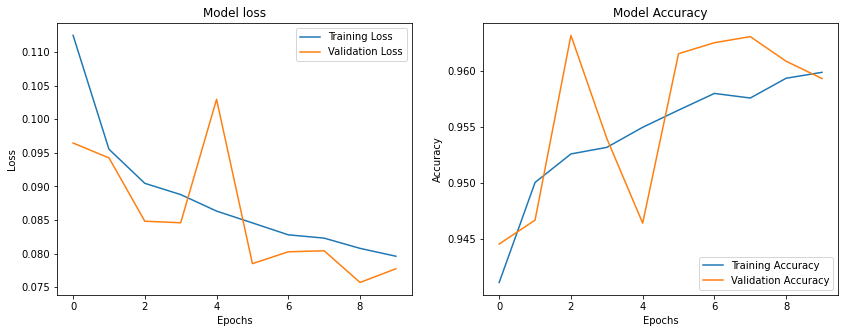

In [98]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 17s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     21216
           1       0.96      0.95      0.95     21648
           2       0.96      0.98      0.97     19459

    accuracy                           0.96     62323
   macro avg       0.96      0.96      0.96     62323
weighted avg       0.96      0.96      0.96     62323

F1 Score:  0.9592493289803684


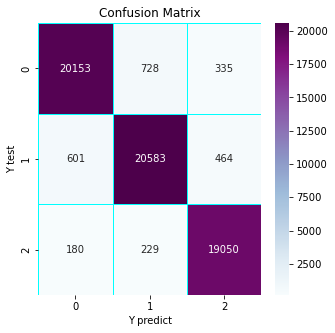

In [99]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test XVII**

In [100]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train.drop(columns=['target', 'RunId','Time']))
test_data_scaled = scaler.transform(df_test.drop(columns=['target', 'RunId','Time']))

In [101]:
target_train = to_categorical(df_train['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train['RunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train['RunId'] == run_id]
    run_target = target_train[df_train['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (119514, 20, 36)
Y train shape: (119514, 3)


In [102]:
target_test = to_categorical(df_test['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test['RunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test['RunId'] == run_id]
    run_target = target_test[df_test['RunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (62323, 20, 36)
Y test shape: (62323, 3)


In [103]:
# Define the LSTM model
model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stopping, lr_reduction])


Epoch 1/50
3735/3735 [==============================] - 118s 30ms/step - loss: 0.1141 - accuracy: 0.9400 - val_loss: 0.0927 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 2/50
3735/3735 [==============================] - 108s 29ms/step - loss: 0.0949 - accuracy: 0.9500 - val_loss: 0.0912 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/50
3735/3735 [==============================] - 104s 28ms/step - loss: 0.0916 - accuracy: 0.9512 - val_loss: 0.0900 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 4/50
3735/3735 [==============================] - 108s 29ms/step - loss: 0.0877 - accuracy: 0.9538 - val_loss: 0.0841 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 5/50
3735/3735 [==============================] - 107s 29ms/step - loss: 0.0842 - accuracy: 0.9560 - val_loss: 0.0885 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 6/50
3735/3735 [==============================] - 104s 28ms/step - loss: 0.0826 - accuracy: 0.9580 - val_loss: 0.0873 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 7/50
3735/3735 [==================

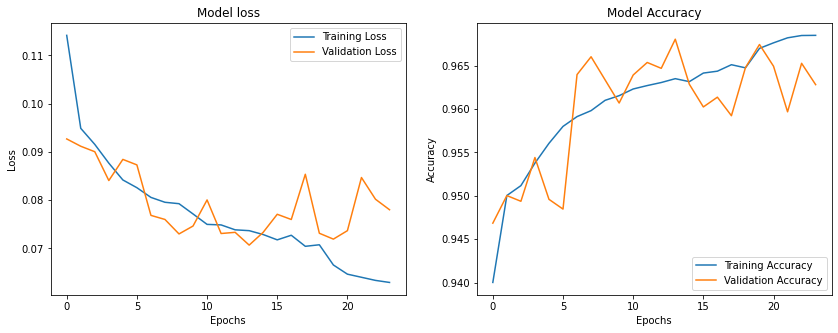

In [104]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1948/1948 [==============================] - 18s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21216
           1       0.95      0.97      0.96     21648
           2       0.98      0.97      0.97     19459

    accuracy                           0.96     62323
   macro avg       0.96      0.96      0.96     62323
weighted avg       0.96      0.96      0.96     62323

F1 Score:  0.9628286716952933


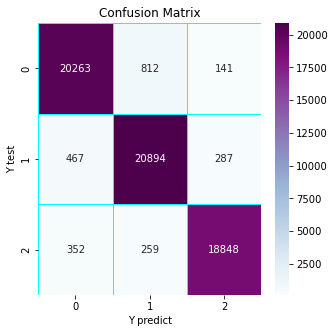

In [105]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

# Results

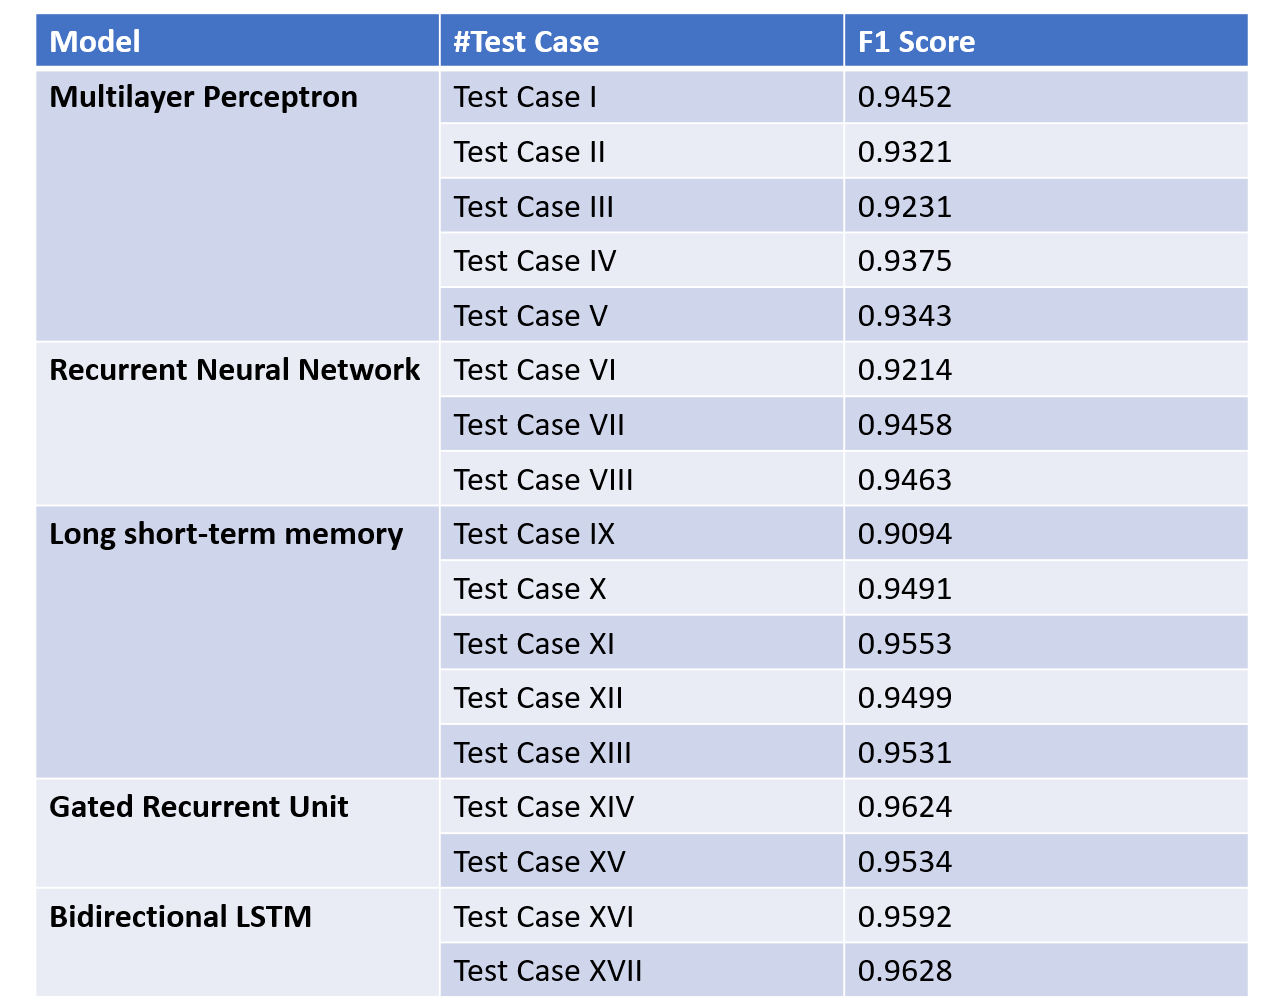